In [42]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from utility import get_data, glasso

# ================================
# SETTINGS
# ================================

ANNUALIZE = False
PERIODS_PER_YEAR = 252

N_RANDOM = 5000
RANDOM_SEED = 42

TICKERS = pd.read_csv('tickers_names.csv')['Ticker'].tolist()[:4]
START_DATE = "2022-01-01"
END_DATE = "2023-01-01"

In [43]:
# # 1) DOWNLOAD/LOAD PRICES AND BUILD DAILY RETURNS

DOWNLOAD = True
if DOWNLOAD:
    returns = get_data(TICKERS, START_DATE, END_DATE, min_coverage=0.90, fill_nan=False, save=True)
else:
    returns = pd.read_csv('returns_data.csv', index_col=0)


# # 2) ESTIMATE/LOAD COVARIANCE AND PRECISION MATRICES USING GLASSO
LOAD = False
if LOAD:
    Sigma_daily = pd.read_csv('covariance_using_return_alpha=0.4.csv', index_col=0)
    Theta_daily = pd.read_csv('precision_using_return_alpha=0.4.csv', index_col=0)
else:
    Sigma_daily, Theta_daily = glasso(alpha=0.4, returns_df=returns, save_outputs=True, max_iter=1000)



[*********************100%***********************]  4 of 4 completed

Kept 4 / 4 tickers with >= 90% coverage
Dropped 25 days with missing data; 227 days remain
✅ Retrieved 4 assets over 227 days


In [44]:
# ================================
# 3) ESTIMATE MEAN VECTOR AND ANNUALIZE IF REQUESTED
# ================================

# Daily mean returns
mu_daily = returns.mean().values.astype(float)  # do the mean over rows (dates)


# Annualize if requested
if ANNUALIZE:
    mu = mu_daily * PERIODS_PER_YEAR
    Sigma = Sigma_daily * PERIODS_PER_YEAR
    Theta = Theta_daily / PERIODS_PER_YEAR  # (c * Σ)^{-1} = (1/c) Σ^{-1}
else:
    mu = mu_daily
    Sigma = Sigma_daily
    Theta = Theta_daily

In [45]:
# ================================
# 4) MARKOWITZ COEFFICIENTS AND FRONTIER (NO RISK-FREE, SHORT ALLOWED)
# ================================
# Theta = Σ^{-1}

def markowitz_coeffs(mu, Theta):
    """Compute A, B, C, D using the precision matrix Theta."""
    ones = np.ones_like(mu)
    A = ones @ Theta @ ones
    B = ones @ Theta @ mu
    C = mu   @ Theta @ mu
    D = A * C - B**2
    return A, B, C, D

A, B, C, D = markowitz_coeffs(mu, Theta)

if D <= 0:
    raise ValueError("D <= 0: something is wrong with Θ or μ.")

def min_variance_portfolio(Theta):
    """Minimum-variance portfolio under 1'w = 1, with short-selling allowed."""
    ones = np.ones(Theta.shape[0])
    A = ones @ Theta @ ones
    w_mv = Theta @ ones / A
    return w_mv

def portfolio_stats(w, mu, Sigma):
    """Compute mean and volatility of portfolio w."""
    var = float(w @ Sigma @ w)
    if var < 0:
        print("Warning: negative variance encountered in portfolio_stats.")
        var = max(var, 0.0)  # numerical safeguard
    ret = float(w @ mu)
    vol = float(np.sqrt(var))
    return ret, vol

w_mv = min_variance_portfolio(Theta)                # weights of min-variance portfolio
ret_mv, vol_mv = portfolio_stats(w_mv, mu, Sigma)   # stats of min-variance portfolio
p_mv = B / A         # theoretical mean of min-variance portfolio

print("ret_mv (from w_mv) =", ret_mv)
print("p_mv (B/A)         =", p_mv)

def efficient_frontier(mu, A, B, C, D, n_points=1000,
                       ret_min=None, ret_max=None,
                       return_full=False,
                       span_mult_full=6.0,   # quanto "larga" la parabola quando return_full=True
                       span_mult_eff=8.0     # quanto estendere verso l'alto per vedere bene la parte efficiente
                      ):
    """
    Markowitz frontier (no risk-free asset, short allowed).

    - return_full=False: ritorna solo il ramo efficiente (p >= p_mv)
    - return_full=True : ritorna tutta la parabola (ramo inefficiente + efficiente)

    ret_min/ret_max: se None, li scegliamo in modo robusto per evitare grafici "schiacciati".
    """
    p_mv = B / A

    mu_min_emp = float(np.min(mu))
    mu_max_emp = float(np.max(mu))

    # "span" robusto: se mu è quasi piatto, evitiamo span=0
    span = mu_max_emp - mu_min_emp
    if span <= 1e-12:
        # fallback: usa una scala basata sulla magnitudine dei rendimenti
        span = max(abs(mu_min_emp), abs(mu_max_emp), abs(p_mv), 1e-4)

    # Default range: centrato su p_mv, abbastanza largo da mostrare chiaramente la curva
    if ret_min is None or ret_max is None:
        if return_full:
            # parabola completa: abbastanza simmetrica intorno a p_mv
            default_min = min(mu_min_emp, p_mv) - span_mult_full * span
            default_max = max(mu_max_emp, p_mv) + span_mult_full * span
        else:
            # ramo efficiente: estendi più verso l'alto
            default_min = min(mu_min_emp, p_mv) - 2.0 * span
            default_max = max(mu_max_emp, p_mv) + span_mult_eff * span

        if ret_min is None:
            ret_min = default_min
        if ret_max is None:
            ret_max = default_max

    p_grid = np.linspace(ret_min, ret_max, n_points)

    sigma2_grid = (A * p_grid**2 - 2 * B * p_grid + C) / D
    sigma2_grid = np.maximum(sigma2_grid, 0.0)
    sigma_grid = np.sqrt(sigma2_grid)

    if return_full:
        return sigma_grid, p_grid, p_mv

    mask_eff = p_grid >= p_mv
    return sigma_grid[mask_eff], p_grid[mask_eff], p_mv



# Compute full Markowitz parabola and efficient part
sigma_all, p_all, p_mv = efficient_frontier(
    mu, A, B, C, D,
    n_points=800,
    ret_min=None,
    ret_max=None,
    return_full=True
)

# efficient part only
mask_eff = p_all >= p_mv
sigma_eff = sigma_all[mask_eff]
p_eff = p_all[mask_eff]


ret_mv (from w_mv) = -0.0006905762287599182
p_mv (B/A)         = -0.0006905762287599182


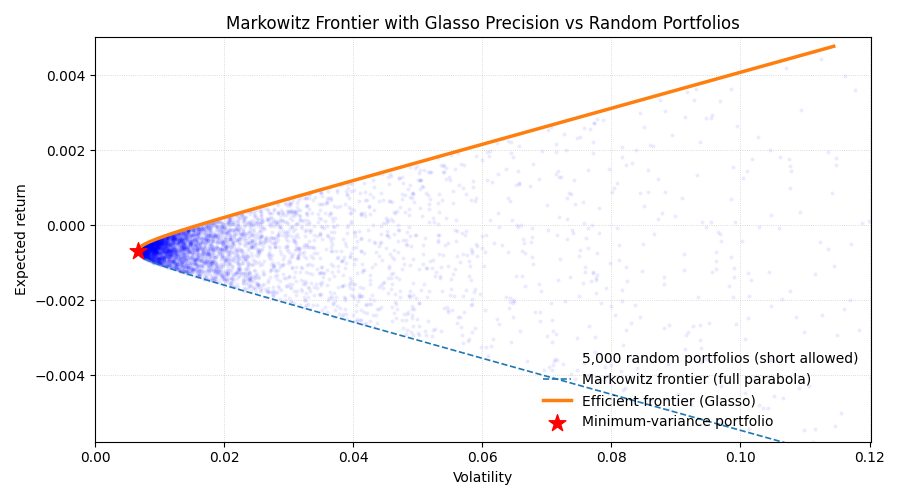

In [46]:
# ================================
# 5) RANDOM PORTFOLIOS (SHORT ALLOWED)
# ================================

def random_portfolios(mu, Sigma, n=N_RANDOM, seed=RANDOM_SEED,
                      vol_clip_q=0.995,   # taglia solo gli outlier estremi
                      ret_clip_q=0.995    # opzionale: taglia anche i return estremi
                     ):
    """
    Random portfolios con short-selling allowed e vincolo 1'w=1.
    Fix: evita divisioni per somme ~0 (che generano pesi enormi/outlier).
    """
    rng = np.random.default_rng(seed)
    n_assets = len(mu)

    W = rng.normal(size=(n, n_assets))
    s = W.sum(axis=1)

    # Evita righe con somma quasi zero -> pesi giganteschi
    ok = np.abs(s) > 1e-8
    W = W[ok]
    s = s[ok]

    W = W / s[:, None]

    rets = W @ mu
    var = np.einsum("ij,jk,ik->i", W, Sigma, W)
    var = np.maximum(var, 0.0)
    vols = np.sqrt(var)

    # Pulizia robusta: taglia solo le code estreme (non metà dei punti)
    v_cut = np.quantile(vols, vol_clip_q)
    r_lo = np.quantile(rets, 1.0 - ret_clip_q)
    r_hi = np.quantile(rets, ret_clip_q)

    mask = (vols <= v_cut) & (rets >= r_lo) & (rets <= r_hi)

    return rets[mask], vols[mask], W[mask]

rp_rets, rp_vols, rp_weights = random_portfolios(mu, Sigma, n=N_RANDOM, seed=RANDOM_SEED)   


# ================================
# 6) PLOT RESULTS
# ================================
fig, ax = plt.subplots(figsize=(9, 5))

# Random portfolios (de-emphasised background)
ax.scatter(
    rp_vols,
    rp_rets,
    s=8,
    alpha=0.08,
    color="blue",
    linewidths=0,
    label=f"{N_RANDOM:,} random portfolios (short allowed)",
    zorder=1,
)

# Full Markowitz parabola (inefficient + efficient)
ax.plot(
    sigma_all,
    p_all,
    lw=1.2,
    linestyle="--",
    color="tab:blue",
    label="Markowitz frontier (full parabola)",
    zorder=2,
)

# Efficient frontier (highlighted)
ax.plot(
    sigma_eff,
    p_eff,
    lw=2.5,
    color="tab:orange",
    label="Efficient frontier (Glasso)",
    zorder=3,
)

# Minimum-variance portfolio marker
ax.scatter(
    [vol_mv],
    [ret_mv],
    marker="*",
    s=160,
    color="red",
    label="Minimum-variance portfolio",
    zorder=4,
)

x_label = "Volatility"
y_label = "Expected return"
if ANNUALIZE:
    x_label += " (annualized)"
    y_label += " (annualized)"

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Markowitz Frontier with Glasso Precision vs Random Portfolios")

# Zoom on the frontier range
x_lo = 0.0
x_hi = float(np.max(sigma_eff)) * 1.05
y_lo = float(np.min(p_all)) * 0.95
y_hi = float(np.max(p_all)) * 1.05
ax.set_xlim(x_lo, x_hi)
ax.set_ylim(y_lo, y_hi)

ax.grid(True, which="both", linestyle=":", linewidth=0.6, alpha=0.6)
ax.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()


In [47]:
# ================================
# 7) PRINT W FOR REFERENCE
# ================================

w_mv_series = pd.Series(w_mv, index=returns.columns).sort_values(ascending=False)
print("\nTop 10 weights in the minimum-variance portfolio (Glasso-based):")
print(w_mv_series.head(10))
print("Sum of weights =", w_mv_series.sum())

# print return of min-variance portfolio
print("Return of min-variance portfolio =", ret_mv)


Top 10 weights in the minimum-variance portfolio (Glasso-based):
Ticker
000001.SS    0.331367
0002.HK      0.297029
0001.HK      0.205054
0011.HK      0.166550
dtype: float64
Sum of weights = 0.9999999999999998
Return of min-variance portfolio = -0.0006905762287599182


Risk-free rate rf       = 1e-06
Tangency portfolio mean = -0.0008330298387547358
Tangency portfolio vol  = 0.007202555732827473


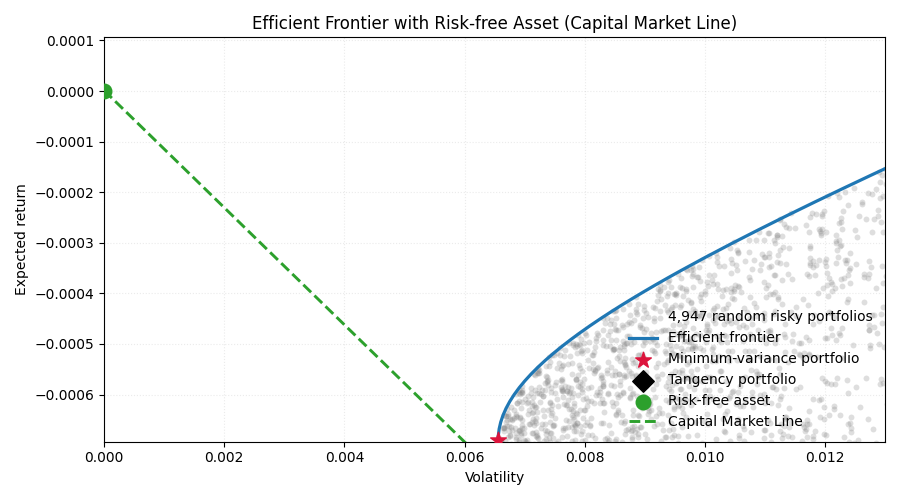

In [ ]:
# ================================
# 8) EFFICIENT FRONTIER WITH A RISK-FREE ASSET
# ================================

# Risk-free rate (same units as mu: daily if ANNUALIZE=False, annual if ANNUALIZE=True)
rf = 0.0001  # example: 0.01% per day; adjust as needed

ones = np.ones_like(mu)
excess = mu - rf * ones   # μ - rf * 1

# (μ - rf1)' Σ^{-1} (μ - rf1)
kappa = float(excess @ Theta @ excess)
if kappa <= 0:
    raise ValueError("kappa <= 0: (μ - rf1)' Σ⁻¹ (μ - rf1) must be positive.")

def min_var_with_rf(p, rf, excess, Theta):
    """
    For a target expected return p > rf, compute the minimized variance (and vol)
    of the optimal risky portfolio satisfying:
        min (1/2) w' Σ w
        s.t. rf + w' μ = p
    using the closed-form:
        σ²_min = (p - rf)² / [(μ - rf1)' Σ⁻¹ (μ - rf1)].
    """
    kappa = float(excess @ Theta @ excess)
    if kappa <= 0:
        raise ValueError("kappa <= 0 in min_var_with_rf.")
    var = (p - rf) ** 2 / kappa
    var = max(var, 0.0)
    return var, np.sqrt(var)

# Tangency portfolio (risky part) – proportional to Σ⁻¹ (μ - rf1)
w_tan_unscaled = Theta @ excess       # Σ⁻¹ (μ - rf1)
sum_w_tan = w_tan_unscaled.sum()
if np.isclose(sum_w_tan, 0.0):
    raise ValueError("Cannot normalize tangency portfolio: sum of weights is ~0.")

w_tan = w_tan_unscaled / sum_w_tan    # scaled so that 1'w* = 1

# Portfolio statistics of the tangency portfolio
ret_tan, vol_tan = portfolio_stats(w_tan, mu, Sigma)

print("Risk-free rate rf       =", rf)
print("Tangency portfolio mean =", ret_tan)
print("Tangency portfolio vol  =", vol_tan)

# Capital Market Line (CML): combinations of rf and tangency portfolio
# p(σ) = rf + ( (μ_tan - rf)/σ_tan ) * σ
max_vol_candidates = [rp_vols.max(), sigma_eff.max(), vol_tan * 2.0]
max_vol_cml = max(v for v in max_vol_candidates if np.isfinite(v))

sigma_cml = np.linspace(0.0, max_vol_cml, 200)
p_cml = rf + (ret_tan - rf) * (sigma_cml / vol_tan)  # straight line through (0, rf) and (σ_tan, μ_tan)

# ================================
# 9) PLOT: RISKY FRONTIER + CML
# ================================

fig, ax = plt.subplots(figsize=(9, 5))

# Keep random portfolios as context but not dominant
ax.scatter(
    rp_vols,
    rp_rets,
    s=18,
    alpha=0.25,
    linewidths=0,
    color="tab:gray",
    label=f"{len(rp_vols):,} random risky portfolios",
    zorder=1,
)

# Efficient frontier (risky assets)
ax.plot(
    sigma_eff,
    p_eff,
    lw=2.3,
    color="tab:blue",
    label="Efficient frontier",
    zorder=3,
)

# Minimum-variance portfolio
ax.scatter(
    [vol_mv],
    [ret_mv],
    marker="*",
    s=140,
    color="crimson",
    label="Minimum-variance portfolio",
    zorder=4,
)

# Tangency portfolio
ax.scatter(
    [vol_tan],
    [ret_tan],
    marker="D",
    s=120,
    color="black",
    label="Tangency portfolio",
    zorder=5,
)

# Risk-free asset
ax.scatter(
    [0.0],
    [rf],
    marker="o",
    s=110,
    color="tab:green",
    label="Risk-free asset",
    zorder=6,
)

# Capital Market Line
ax.plot(
    sigma_cml,
    p_cml,
    lw=2.1,
    linestyle="--",
    color="tab:green",
    label="Capital Market Line",
    zorder=2,
)

# Axis labels and focus on the relevant range
x_label = "Volatility"
y_label = "Expected return"
if ANNUALIZE:
    x_label += " (annualized)"
    y_label += " (annualized)"

x_hi = max(float(np.nanmax(sigma_eff)), float(np.nanmax(sigma_cml)))*0.01
ax.set_xlim(0.0, x_hi)

y_lo = min(float(rf), float(np.nanmin(p_eff)))
y_hi = max(float(np.nanmax(p_eff)), float(np.nanmax(p_cml)))*0.01
pad = 0.08 * (y_hi - y_lo) if (y_hi - y_lo) > 0 else 1e-4
ax.set_ylim(y_lo - 0.2 * pad, y_hi + pad)



ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Efficient Frontier with Risk-free Asset (Capital Market Line)")
ax.grid(alpha=0.25, linestyle=":", linewidth=0.8)
ax.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()


In [49]:
# ================================
# 10) DISPLAY TANGENCY PORTFOLIO WEIGHTS
# ================================

w_tan_series = pd.Series(w_tan, index=returns.columns).sort_values(ascending=False)

print("Top 10 weights in the tangency portfolio (risky part only):")
print(w_tan_series.head(10))
print("\nSum of tangency weights (risky assets) =", w_tan_series.sum())
print("Tangency portfolio expected return     =", ret_tan)
print("Tangency portfolio volatility          =", vol_tan)
print("Risk-free rate                         =", rf)


Top 10 weights in the tangency portfolio (risky part only):
Ticker
0002.HK      0.437727
000001.SS    0.363939
0011.HK      0.115922
0001.HK      0.082412
dtype: float64

Sum of tangency weights (risky assets) = 1.0
Tangency portfolio expected return     = -0.0008151910689101018
Tangency portfolio volatility          = 0.007056671041930103
Risk-free rate                         = 0.0001
